In [4]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os

num_nodes = 10
num_tasks_per_node = 128
num_forecasters = int(1e6)
current_dir = os.getcwd()

data_folder = "data/"
logs_folder = "logs/"

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)

if num_tasks_per_node > 128:
    print("The number of tasks per node should be less than or equal to 128")
    exit(1)

# Read the launch.sh file
with open('launch.sh', 'r') as file:
    launch_script = file.read()

launch_script = launch_script.format(
    num_nodes=num_nodes,
    num_tasks_per_node=num_tasks_per_node,
    current_dir=current_dir,
    world_size=num_nodes*num_tasks_per_node,
    num_forecasters=num_forecasters,
    timings_filename=f"{data_folder}/timings_one_milion.txt",
)

# Print the content of the launch.sh file
print(launch_script)

# Save the sbatch script to a temporary file
script_filename = "submit_job.sh"
with open(script_filename, "w") as script_file:
    script_file.write(launch_script)

# Submit the job using the sbatch command
os.system(f"sbatch {script_filename}")

# Remove the temporary file
os.remove(script_filename)

#!/bin/bash -l

#SBATCH --job-name=ensemble_forecasters
#SBATCH --output=logs/output_%j.txt
#SBATCH --error=logs/error_%j.txt
#SBATCH --nodes=10
#SBATCH --ntasks-per-node=128
#SBATCH --ntasks-per-socket=16
#SBATCH --cpus-per-task=1
#SBATCH --time=00:30:00

cd /mnt/aiongpfs/users/lgreco/Development/ML4HPC/ensemble_of_forecasters
eval "$(micromamba shell hook --shell bash)"
micromamba activate ensemble_venv
module load mpi/OpenMPI/4.0.5-GCC-10.2.0
mpirun -n 1280 python ensemble_of_forecasters.py 1000000
Submitted batch job 4416319


(1000000, 5, 2)
(1000000, 2, 6)
(1000000, 1)


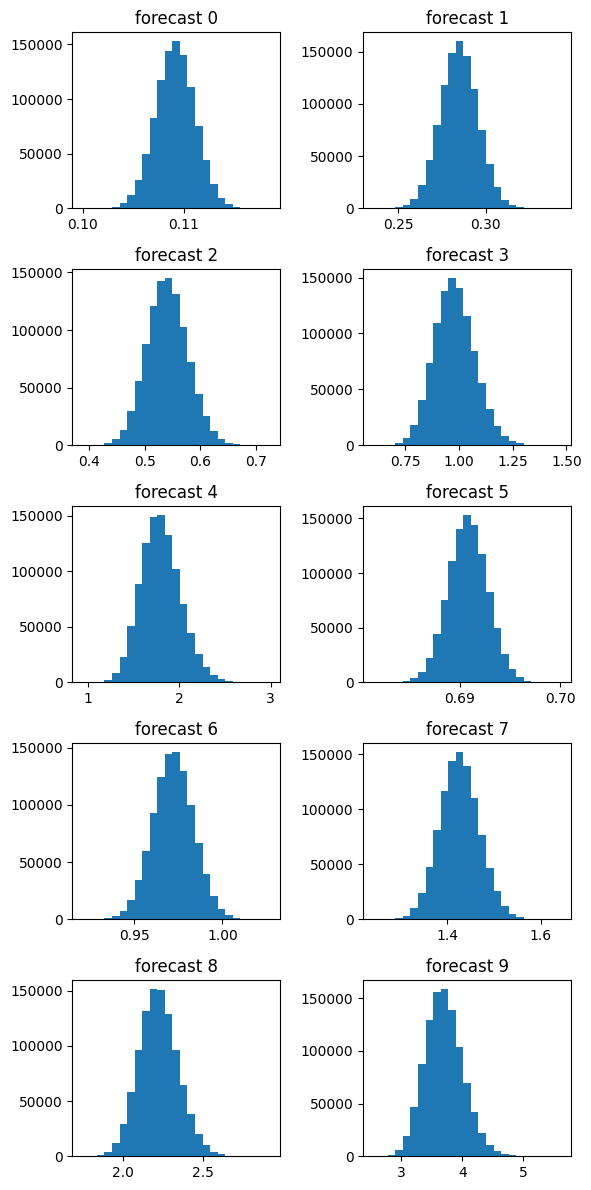

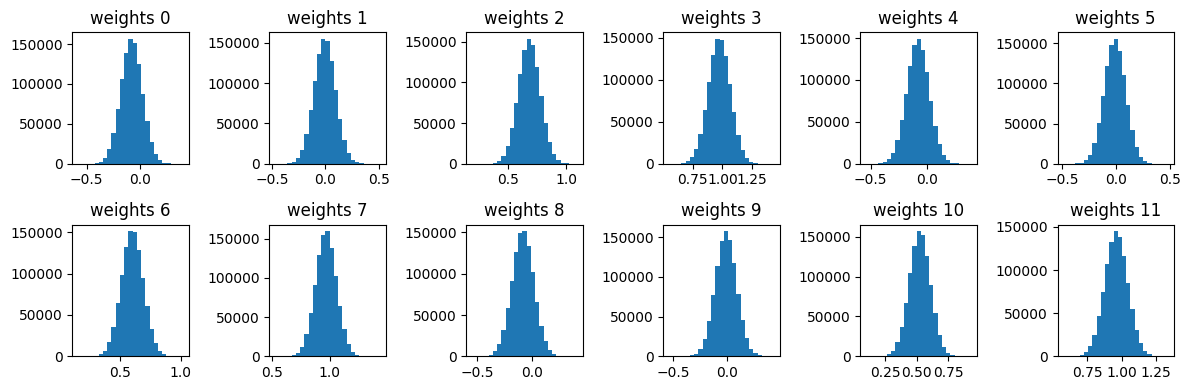

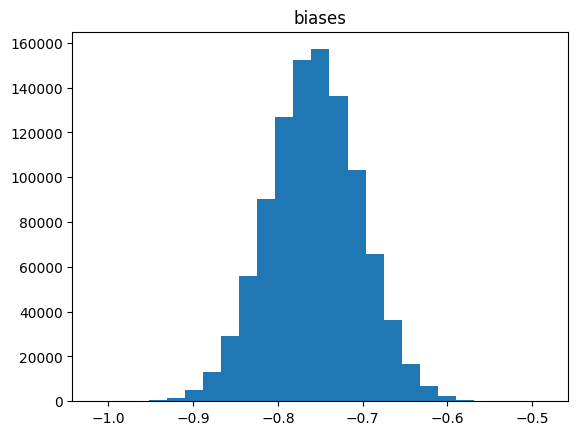

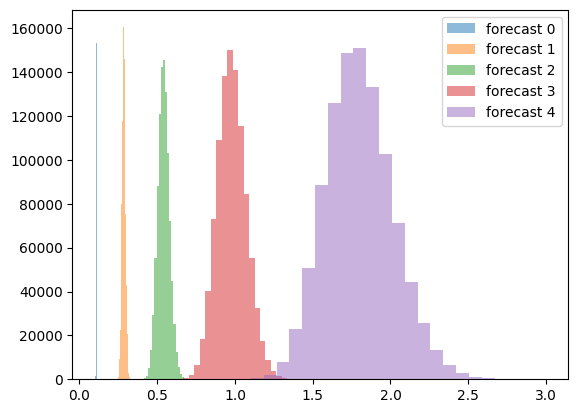

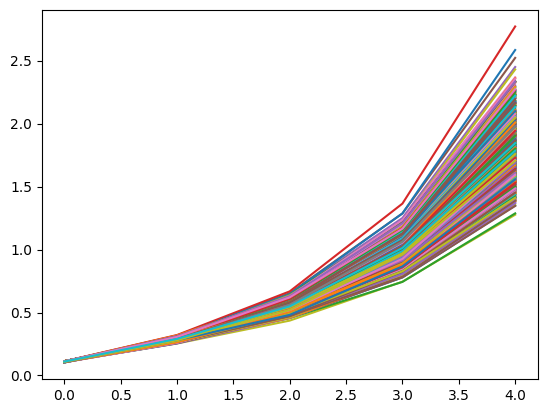

In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

forecast = np.load("data/forecasting.npy")
weights = np.load("data/weights.npy")
biases = np.load('data/biases.npy')

print(forecast.shape)
print(weights.shape)
print(biases.shape)

n_bins = 25

## FORECASTER PLOT
variable = forecast
fig, axs = plt.subplots(5, 2, figsize=(6, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot histograms in each subplot
for z in range(variable.shape[2]):
    for y in range(variable.shape[1]):
        f_list = []
        for x in range(variable.shape[0]):
            f_list.append(variable[x][y][z])
        axs[z*variable.shape[1]+y].hist(f_list, bins=n_bins)
        axs[z*variable.shape[1]+y].set_title(f'forecast {z*variable.shape[1]+y}')
f_list = []

plt.tight_layout()
plt.show()

## WEIGHTS PLOT
variable = weights
fig, axs = plt.subplots(variable.shape[1], variable.shape[2], figsize=(12, 4))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot histograms in each subplot
for z in range(variable.shape[2]):
    for y in range(variable.shape[1]):
        f_list = []
        for x in range(variable.shape[0]):
            f_list.append(variable[x][y][z])
        axs[z*variable.shape[1]+y].hist(f_list, bins=n_bins)
        axs[z*variable.shape[1]+y].set_title(f'weights {z*variable.shape[1]+y}')
f_list = []

plt.tight_layout()
plt.show()

## BIASES PLOT
variable = biases

# Plot histograms of f_list
for x in range(variable.shape[0]):
    f_list.append(variable[x][0])

plt.hist(f_list, bins=n_bins)
#Put a name
plt.title('biases')


forecasted_values_tot = []
## PLOT OF THE FORECASTED VALUES
for j in range(forecast.shape[1]):
    forecasted = []
    for i in range(forecast.shape[0]):
        forecasted.append(forecast[i][j][0])
    forecasted_values_tot.append(forecasted)

# New figure for a new plot
plt.figure()
# Plot the hist forecasted values in the same graph with different colours
for i in range(5):
    plt.hist(forecasted_values_tot[i], bins=n_bins, alpha=0.5, label=f'forecast {i}')

plt.legend()


forecasted_values_tot = []
## PLOT OF THE FORECASTED VALUES
for i in range(1000):
    forecasted = []
    
    for j in range(5):
        forecasted.append(forecast[i][j][0])
    
    forecasted_values_tot.append(forecasted)

plt.figure()

# plot the lines
for i in range(1000):
    plt.plot(forecasted_values_tot[i], label=f'forecast {i}')




Strong scalability test:


In [8]:
import time

# Function to submit a job to the supercomputer
def submit_job(num_nodes, num_tasks_per_node, num_forecasters, execution_time_file):
    current_dir = os.getcwd()
    data_folder = "data/"
    logs_folder = "logs/"

    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    if not os.path.exists(logs_folder):
        os.makedirs(logs_folder)

    # Read the launch.sh file
    with open('launch.sh', 'r') as file:
        launch_script = file.read()

    # Configure the launch script
    launch_script = launch_script.format(
        num_nodes=num_nodes,
        num_tasks_per_node=num_tasks_per_node,
        current_dir=current_dir,
        world_size=num_nodes * num_tasks_per_node,
        num_forecasters=num_forecasters,
        timings_filename=execution_time_file,
    )

    print(launch_script)

    # Save and submit the job script
    script_filename = f"submit_job_{num_nodes}_nodes_strong_scalability.sh"
    with open(script_filename, "w") as script_file:
        script_file.write(launch_script)

    os.system(f"sbatch {script_filename}")
    os.remove(script_filename)

# Define test parameters
num_nodes_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of nodes to test
num_tasks_per_node = 128       # Fixed tasks per node
num_forecasters = int(1e5)     # Fixed problem size
execution_times = []

# Submit jobs for each test configuration
for num_nodes in num_nodes_list:
    execution_time_file = f"data/execution_time_{num_nodes}_strong_scalability.txt"
    print(f"Submitting job for {num_nodes} nodes...")
    submit_job(num_nodes, num_tasks_per_node, num_forecasters, execution_time_file)

    while not os.path.exists(execution_time_file):
        time.sleep(10)  # Poll every 10 seconds
    with open(execution_time_file, "r") as f:
        execution_time = float(f.read())
    execution_times.append(execution_time)
    print(f"Execution time for {num_nodes} nodes: {execution_time} seconds")


Submitting job for 1 nodes...
#!/bin/bash -l

#SBATCH --job-name=ensemble_forecasters
#SBATCH --output=logs/output_%j.txt
#SBATCH --error=logs/error_%j.txt
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=128
#SBATCH --ntasks-per-socket=16
#SBATCH --cpus-per-task=1
#SBATCH --time=00:30:00

cd /mnt/aiongpfs/users/lgreco/Development/ML4HPC/ensemble_of_forecasters
eval "$(micromamba shell hook --shell bash)"
micromamba activate ensemble_venv
module load mpi/OpenMPI/4.0.5-GCC-10.2.0
mpirun -n 128 python ensemble_of_forecasters.py 100000 data/execution_time_1_strong_scalability.txt
Submitted batch job 4416547
Execution time for 1 nodes: 103.4380316734314 seconds
Submitting job for 2 nodes...
#!/bin/bash -l

#SBATCH --job-name=ensemble_forecasters
#SBATCH --output=logs/output_%j.txt
#SBATCH --error=logs/error_%j.txt
#SBATCH --nodes=2
#SBATCH --ntasks-per-node=128
#SBATCH --ntasks-per-socket=16
#SBATCH --cpus-per-task=1
#SBATCH --time=00:30:00

cd /mnt/aiongpfs/users/lgreco/Development/ML4HPC/ense

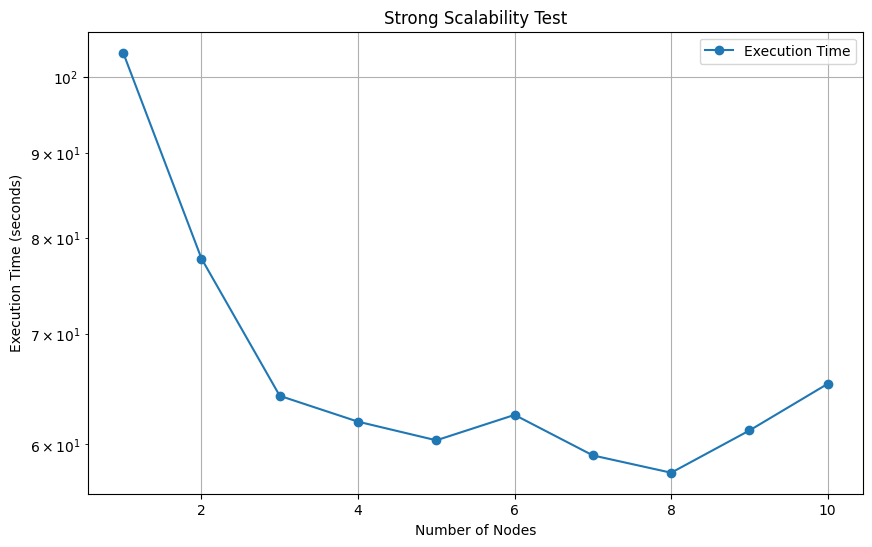

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.plot(num_nodes_list, execution_times, marker='o', label='Execution Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Execution Time (seconds)')
plt.title('Strong Scalability Test')
plt.grid(True)
plt.legend()
plt.savefig("scalability_plot.png") 
plt.show()

Weak scalability test:


In [5]:

# Function to submit a job to the supercomputer
def submit_job(num_nodes, num_tasks_per_node, num_forecasters_per_node, execution_time_file):
    current_dir = os.getcwd()
    data_folder = "data/"
    logs_folder = "logs/"

    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    if not os.path.exists(logs_folder):
        os.makedirs(logs_folder)

    # Read the launch.sh file
    with open('launch.sh', 'r') as file:
        launch_script = file.read()

    # Configure the launch script
    total_forecasters = num_nodes * num_forecasters_per_node
    launch_script = launch_script.format(
        num_nodes=num_nodes,
        num_tasks_per_node=num_tasks_per_node,
        current_dir=current_dir,
        world_size=num_nodes * num_tasks_per_node,
        num_forecasters=total_forecasters,
        timings_filename=execution_time_file,
    )

    print(launch_script)

    # Save and submit the job script
    script_filename = f"submit_job_{num_nodes}_nodes_weak_scalability.sh"
    with open(script_filename, "w") as script_file:
        script_file.write(launch_script)

    os.system(f"sbatch {script_filename}")
    os.remove(script_filename)

# Define test parameters
num_nodes_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of nodes to test
num_tasks_per_node = 128        # Fixed tasks per node
num_forecasters_per_node = int(1e5)  # Fixed workload per node
execution_times = []

# Submit jobs for each test configuration
for num_nodes in num_nodes_list:
    execution_time_file = f"data/execution_time_{num_nodes}_weak_scalability.txt"
    if not os.path.exists(execution_time_file):
        print(f"Submitting job for {num_nodes} nodes...")
        submit_job(num_nodes, num_tasks_per_node, num_forecasters_per_node, execution_time_file)

    # Wait for the job to complete and fetch execution time
    while not os.path.exists(execution_time_file):
        time.sleep(10)  # Poll every 10 seconds
    with open(execution_time_file, "r") as f:
        execution_time = float(f.read())
    execution_times.append(execution_time)
    print(f"Execution time for {num_nodes} nodes: {execution_time} seconds")



Execution time for 1 nodes: 107.17572450637817 seconds
Execution time for 2 nodes: 147.22275114059448 seconds
Execution time for 3 nodes: 195.7890043258667 seconds
Execution time for 4 nodes: 238.0878405570984 seconds
Execution time for 5 nodes: 284.02449321746826 seconds
Execution time for 6 nodes: 326.1796061992645 seconds
Execution time for 7 nodes: 380.2805881500244 seconds
Execution time for 8 nodes: 419.5690088272095 seconds
Execution time for 9 nodes: 463.32055854797363 seconds
Execution time for 10 nodes: 511.7296071052551 seconds


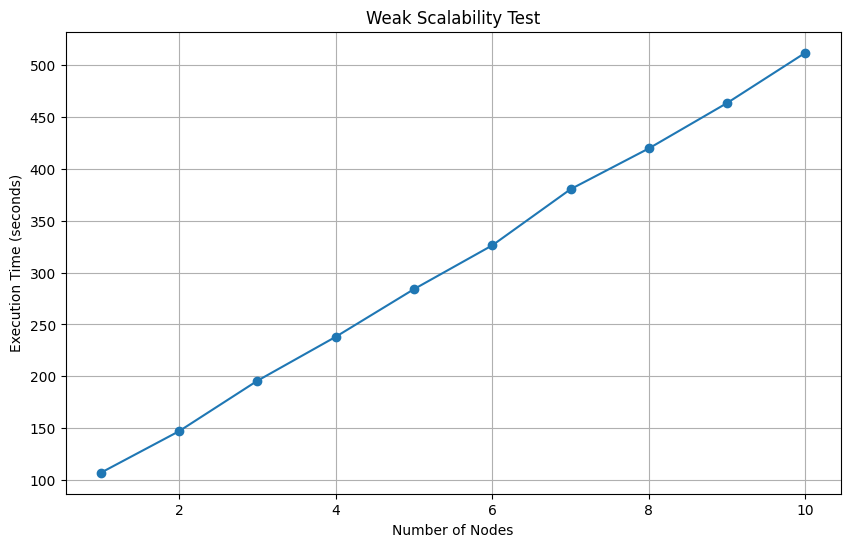

In [6]:

# Plot the weak scalability results
plt.figure(figsize=(10, 6))
plt.plot(num_nodes_list, execution_times, marker="o")
plt.xlabel("Number of Nodes")
plt.ylabel("Execution Time (seconds)")
plt.title("Weak Scalability Test")
plt.grid(True)
plt.savefig("weak_scalability.png")
plt.show()